/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-1-801d54cc3089>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Emotion', data=emotion_df.head(10), palette='viridis')


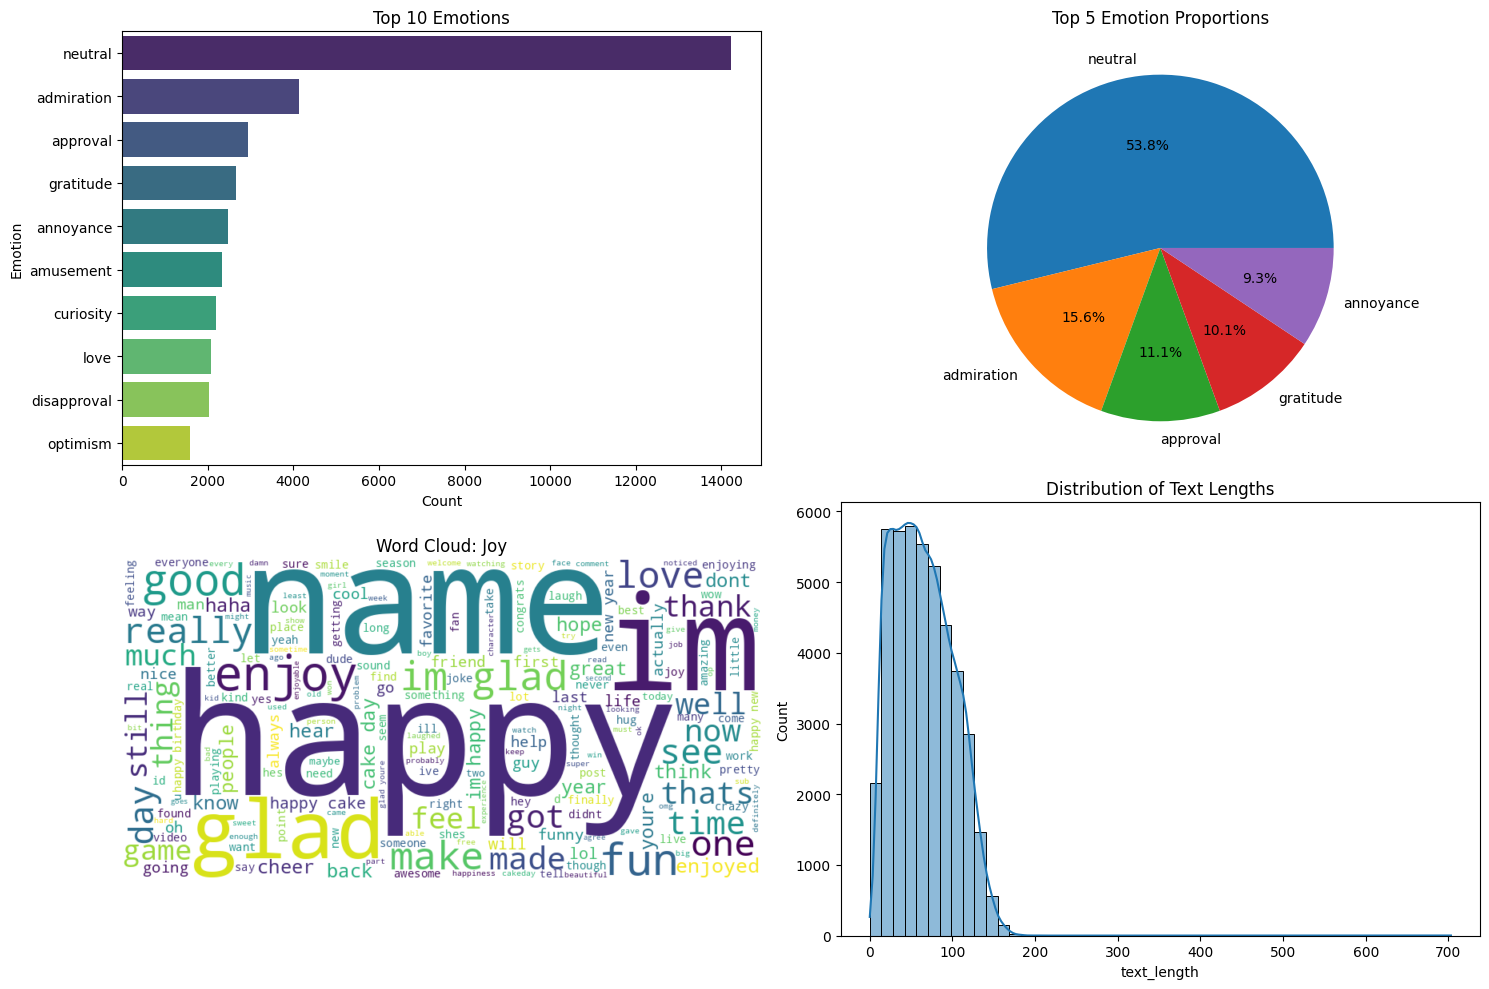

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the dataset
df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/simplified/train-00000-of-00001.parquet")

# Define emotion labels (GoEmotions has 28 classes)
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]

# --- Data Preprocessing ---
def preprocess_text(text):
    """Clean text data."""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+|[^\w\s]', '', text)  # Remove URLs, mentions, punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Convert numeric labels to emotion names
def get_emotion_names(label_indices):
    return [emotion_labels[idx] for idx in label_indices]

df['emotions'] = df['labels'].apply(get_emotion_names)

# --- EDA: Emotion Distribution ---
# Flatten all emotion labels and count frequencies
all_emotions = [emotion for sublist in df['emotions'] for emotion in sublist]
emotion_counts = Counter(all_emotions)

# Convert to DataFrame for plotting
emotion_df = pd.DataFrame(emotion_counts.most_common(), columns=['Emotion', 'Count'])

# --- Visualizations ---
plt.figure(figsize=(15, 10))

# 1. Bar Plot (Top Emotions)
plt.subplot(2, 2, 1)
sns.barplot(x='Count', y='Emotion', data=emotion_df.head(10), palette='viridis')
plt.title('Top 10 Emotions')

# 2. Pie Chart (Emotion Proportions)
plt.subplot(2, 2, 2)
plt.pie(emotion_df['Count'].head(5), labels=emotion_df['Emotion'].head(5), autopct='%1.1f%%')
plt.title('Top 5 Emotion Proportions')

# 3. Word Cloud for Most Common Emotion (e.g., Joy)
plt.subplot(2, 2, 3)
joy_texts = ' '.join(df[df['emotions'].apply(lambda x: 'joy' in x)]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(joy_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Joy')

# 4. Text Length Distribution
plt.subplot(2, 2, 4)
df['text_length'] = df['cleaned_text'].apply(len)
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')

plt.tight_layout()
plt.show()

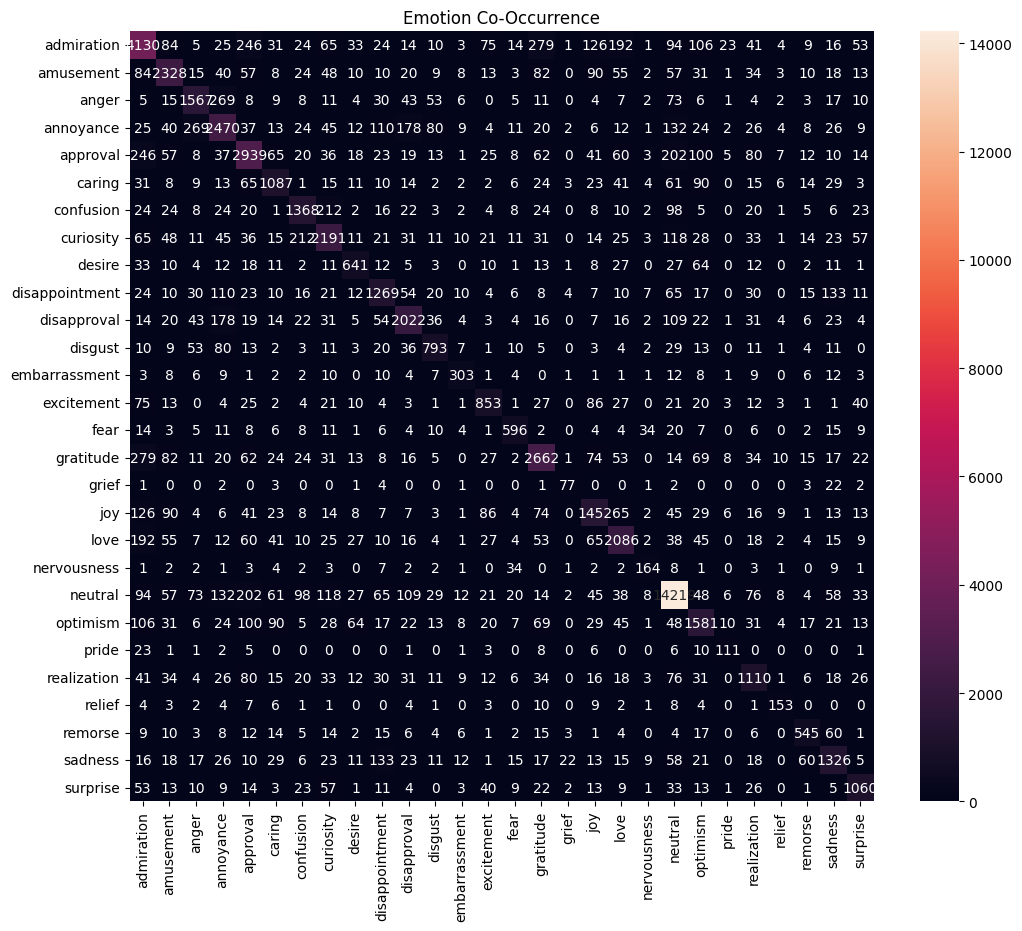

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Create binary matrix of emotions
mlb = MultiLabelBinarizer()
emotion_matrix = mlb.fit_transform(df['emotions'])
co_occurrence = emotion_matrix.T @ emotion_matrix  # Dot product

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, annot=True, fmt='d', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title('Emotion Co-Occurrence')
plt.show()

<ipython-input-3-0ee7a7028c66>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


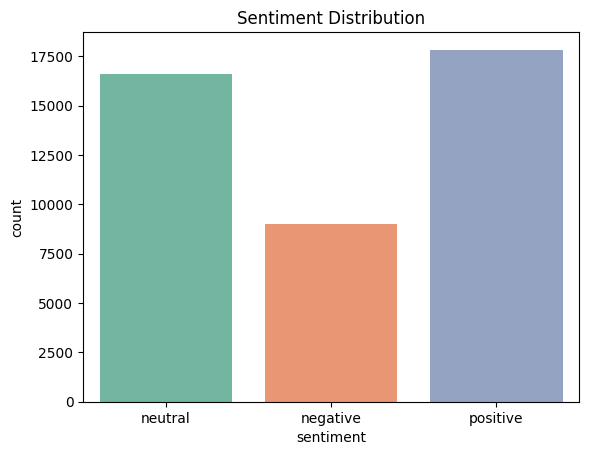

In [ ]:
# Group emotions by sentiment (positive/negative/neutral)
sentiment_map = {
    'positive': ['joy', 'love', 'admiration', 'amusement', 'approval', 'caring', 'excitement', 'gratitude', 'optimism', 'pride', 'relief', 'surprise'],
    'negative': ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness'],
    'neutral': ['neutral', 'confusion', 'curiosity', 'desire', 'realization']
}

# Count sentiment categories
df['sentiment'] = df['emotions'].apply(
    lambda x: next((k for k, v in sentiment_map.items() if any(emotion in v for emotion in x)), 'neutral')
)
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.show()